In [1]:
import os
import shutil
from time import sleep
from pprint import pprint

import tensorflow as tf
import numpy as np

from batchflow.models.tf import EfficientNetB0, EfficientNetB1, EfficientNetB2

from batchflow import Pipeline, B, V, C, D, ImagesBatch
from batchflow.opensets import CIFAR10
from batchflow.research import Option, Research, Results


W0913 10:18:43.043675 140241434658624 deprecation_wrapper.py:119] From /media/data/Data/source/github/analysiscenter/batchflow/batchflow/models/tf/losses/dice.py:6: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0913 10:18:43.045180 140241434658624 deprecation_wrapper.py:119] From /media/data/Data/source/github/analysiscenter/batchflow/batchflow/models/tf/losses/dice.py:6: The name tf.losses.Reduction is deprecated. Please use tf.compat.v1.losses.Reduction instead.

W0913 10:18:43.048959 140241434658624 deprecation_wrapper.py:119] From /media/data/Data/source/github/analysiscenter/batchflow/batchflow/models/tf/base.py:22: The name tf.losses.mean_squared_error is deprecated. Please use tf.compat.v1.losses.mean_squared_error instead.

W0913 10:18:43.049779 140241434658624 deprecation_wrapper.py:119] From /media/data/Data/source/github/analysiscenter/batchflow/batchflow/models/tf/base.py:23: The name tf.losses.sigmoid_cross_entropy is deprecated. Please 

In [2]:
cifar = CIFAR10(batch_class=ImagesBatch, bar=True)


7it [02:52, 20.61s/it]                        


In [3]:
# new_res = EfficientNetB0.resolution
# im_shape = (new_res, new_res, 3)

model_config = {
    'inputs/images/shape': B('image_shape'), #im_shape,
    'inputs/labels/classes': D('num_classes'),
    'initial_block/inputs': 'images',
    'loss': 'ce'
}

train_ppl = (cifar.train.p
#                   .resize((new_res, new_res))
                  .init_variable('loss_history', default=[])
                  .init_model('dynamic', EfficientNetB1, 'model', config=model_config)
                  .to_array()
                  .train_model('model', fetches='loss', images=B('images'), labels=B('labels'), 
                               save_to=V('loss_history', mode='a'))
                  .run_later(64, shuffle=True, n_epochs=1, drop_last=True))

In [4]:
train_ppl = train_ppl.run(bar=True)

  0%|          | 0/781 [00:00<?, ?it/s]W0913 10:21:36.074784 140241434658624 deprecation_wrapper.py:119] From /media/data/Data/source/github/analysiscenter/batchflow/batchflow/models/tf/base.py:319: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0913 10:21:36.075752 140241434658624 deprecation_wrapper.py:119] From /media/data/Data/source/github/analysiscenter/batchflow/batchflow/models/tf/base.py:321: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0913 10:21:36.083170 140241434658624 deprecation_wrapper.py:119] From /media/data/Data/source/github/analysiscenter/batchflow/batchflow/models/tf/base.py:380: The name tf.get_variable_scope is deprecated. Please use tf.compat.v1.get_variable_scope instead.

W0913 10:21:36.096940 140241434658624 deprecation.py:323] From /media/data/Data/source/github/analysiscenter/batchflow/batchflow/models/tf/layers/conv.py:26: conv2d (from tensorflow.python.layers.convolutio

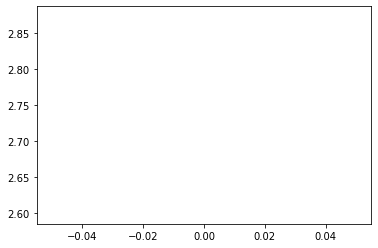

In [5]:
from matplotlib import pyplot as plt
plt.plot(train_ppl.get_variable('loss_history'))

In [6]:
test_pipeline = (cifar.test.p
                .import_model('model', train_ppl)
                .init_variable('predictions') 
                .init_variable('metrics') 
                .to_array()
                .predict_model('model', fetches='predictions', 
                               images=B('images'),
                               save_to=V('predictions'))
                .gather_metrics('class', targets=B('labels'), predictions=V('predictions'),
                                fmt='logits', axis=-1, save_to=V('metrics', mode='u'))
                .run(64, shuffle=True, n_epochs=1, drop_last=False, bar=True)
)

100%|██████████| 157/157 [01:07<00:00,  1.57it/s]


In [7]:
metrics = test_pipeline.get_variable('metrics')

metrics.evaluate('accuracy')

0.1

In [8]:
boom

NameError: name 'boom' is not defined

In [10]:
from batchflow.models.tf import MobileNet_v2, VGG7


In [9]:
train_ppl = (cifar.train.p
                  .init_variable('loss') 
                  .init_model('dynamic', VGG7, 'efficientnet', config=model_config)
                  .to_array()
                  .train_model('efficientnet', fetches='loss',
                               images=B('images'), labels=B('labels'), 
                               save_to=V('loss'))
             .run_later(64, shuffle=True, n_epochs=None))

test_ppl = (cifar.test.p
                 .import_model('efficientnet', C('import_from'))
                 .init_variable('loss')
                 .init_variable('predictions')
                 .init_variable('metrics')
                 .to_array()
                 .predict_model('efficientnet', fetches=['loss', 'predictions'],
                                images=B('images'), labels=B('labels'), 
                                save_to=[V('loss'), V('predictions')])
                 .gather_metrics('class', targets=B('labels'), predictions=V('predictions'),
                                 fmt='logits', axis=-1, save_to=V('metrics', mode='u'))
            .run_later(64, shuffle=True, n_epochs=1))


In [11]:
grid = Option('model', [MobileNet_v2, VGG7])

list(grid.gen_configs())

[ConfigAlias({'model': 'MobileNet_v2'}), ConfigAlias({'model': 'VGG7'})]

In [12]:
research = (Research()
            .add_pipeline(train_ppl, variables='loss', name='train')
            .add_pipeline(test_ppl, variables='loss', name='test', execute=10,
                          run=True, import_from='train')
            .get_metrics(pipeline='test', metrics_var='metrics', metrics_name='accuracy',
                         returns='accuracy', execute=10)
            .add_grid(grid))

In [13]:
!rm -r efficient_net_research

In [ ]:
NUM_REPEATS = 1
NUM_ITERS = 10
research_name = 'efficient_net_research'

research.run(n_reps=NUM_REPEATS, n_iters=NUM_ITERS, name=research_name, bar=True, workers=2, gpu=[6,7])


Research efficient_net_research is starting...


  0%|          | 0/600 [00:00<?, ?it/s]

Distributor has 6 jobs with 100 iterations. Totally: 600


  0%|          | 2/600 [05:24<26:55:15, 162.07s/it]

In [ ]:
res = research.load_results(use_alias=True)
res.info()

In [ ]:
from batchflow.utils import plot_results_by_config

plot_results_by_config(res, (('train', 'loss'), ('test', 'loss'), ('test_metrics', 'accuracy')))